Makemore: part 5

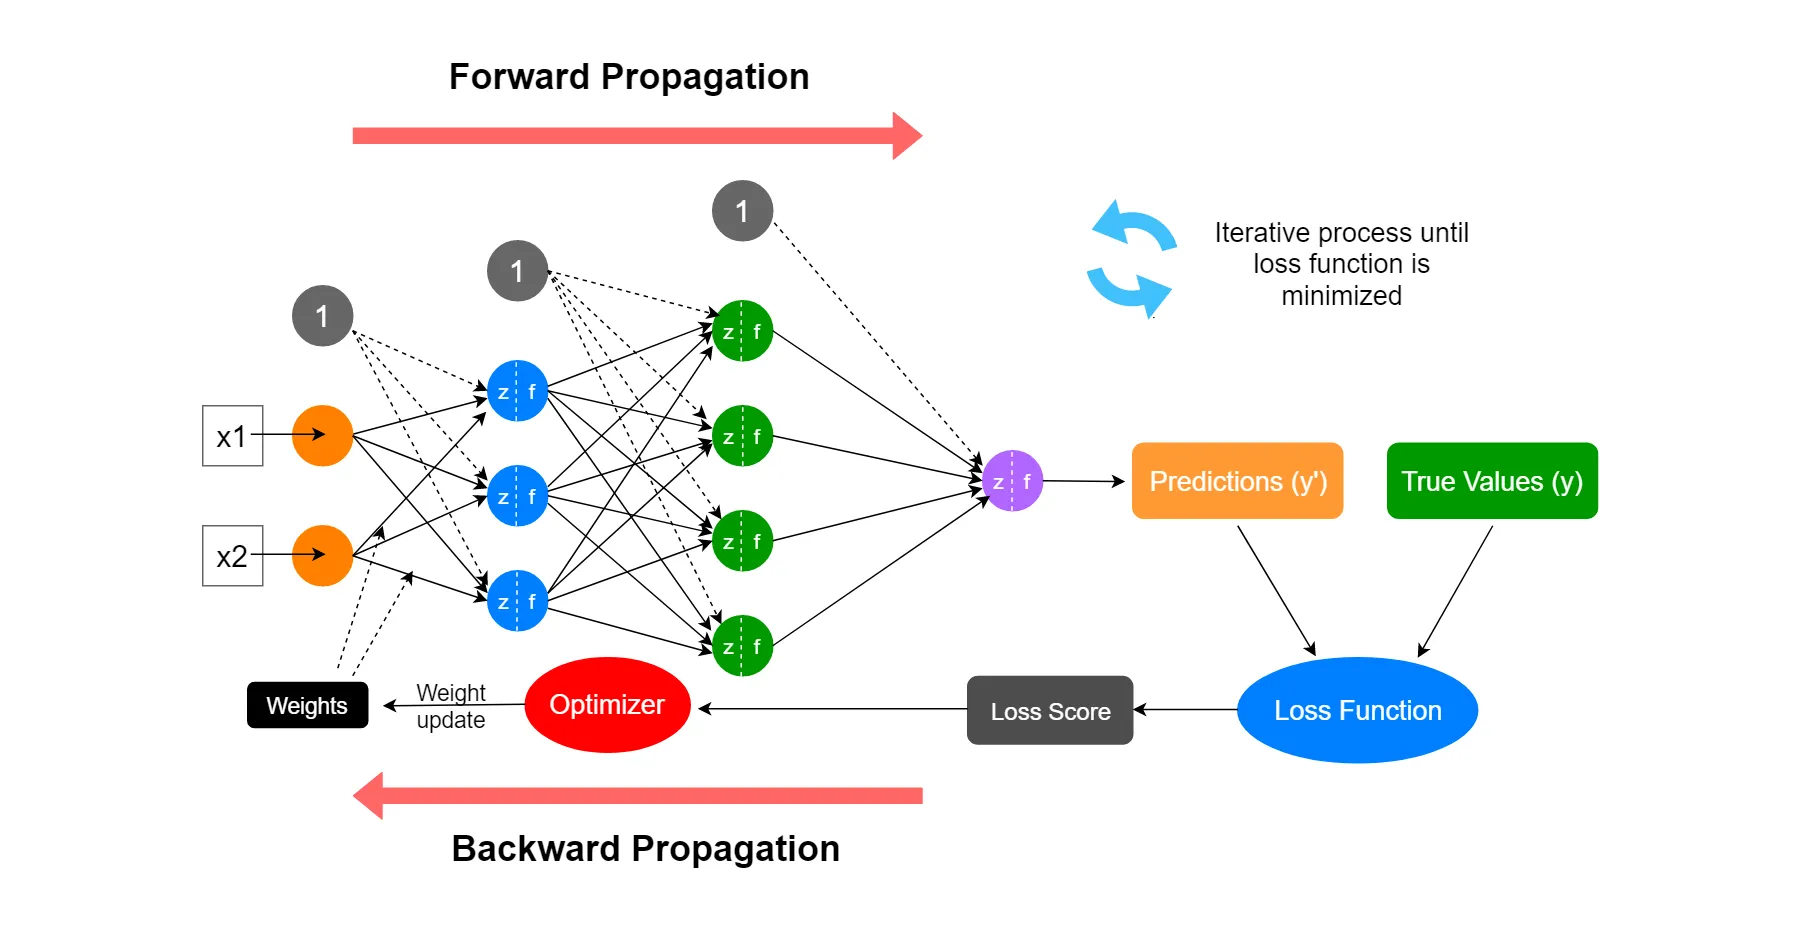

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

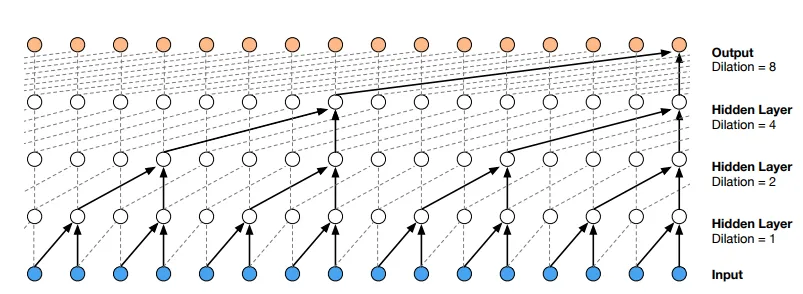

In [4]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words)))) # alphabet
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [145]:
block_size = 8

# function to build data set with train/dev/test splits
def build_dataset(words):
    X, Y = [], []  # X is input, Y is label
    for w in words:
        context = [0] * block_size # initialize context by padding with 0
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop & append

    X = torch.tensor(X) # X contains indexes of input letters
    Y = torch.tensor(Y) # Y contains indexes of output letters
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182437, 8]) torch.Size([182437])
torch.Size([22781, 8]) torch.Size([22781])
torch.Size([22928, 8]) torch.Size([22928])


In [146]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

........ ---> t
.......t ---> a
......ta ---> u
.....tau ---> r
....taur ---> e
...taure ---> n
..tauren ---> .
........ ---> s
.......s ---> u
......su ---> l
.....sul ---> e
....sule ---> m
...sulem ---> a
..sulema ---> n
.suleman ---> .
........ ---> z
.......z ---> e
......ze ---> r
.....zer ---> e
....zere ---> n


In [28]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # Gaussian (normal) distribution
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [29]:
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True # train vs val state - to use the correct mean and var
        # parameters (trained with back propagation)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained wtih a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self,x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)              # batch mean
            xvar = x.var(0, keepdim=True, unbiased=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]


In [30]:
class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [60]:
class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]

In [185]:
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []

In [175]:
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        # Get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [62]:
torch.manual_seed(42);

`Note`: Batch dimension is processed in parallel

In [194]:
n_embd = 10                                         # the dimensionality of the character embedding vectors
n_hidden = 200                                      # the no. of neurons in the hidden layer of the MLP
vocab_size = 27

C = torch.randn((vocab_size, n_embd))
model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(fan_in=(n_embd * 2), fan_out=n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(fan_in=(n_hidden * 2), fan_out=n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(fan_in=(n_hidden * 2), fan_out=n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    # last layer: make less conffident
    model.layers[-1].weight *= 0.1
    # layers[-1].gamma *= 0.1 # weight equivalent on batchNorm layer
    # all other layers: apply gain
    # for layer in layers[:-1]:
    #     if isinstance(layer, Linear):
    #         layer.weight *= 5/3                  # gain value for Tanh

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))         # no. of parameters in total

for p in parameters:
    p.requires_grad = True

170897


`Note`:
- avoid crushing too much information too fast
- for this example, simply increasing the block size will force too much information

In [195]:
# optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters: # Stochastic gradient descent
        p.data += -lr * p.grad

    # track stats
    if i % (max_steps/10) == 0 or i == max_steps-1: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    # if i == 1000:
    #     break # AFTER_DEBUG: would take out to run full optimization

      0/ 200000: 3.3052
  20000/ 200000: 1.6843
  40000/ 200000: 1.9984
  60000/ 200000: 1.8472
  80000/ 200000: 1.8944
 100000/ 200000: 1.9284
 120000/ 200000: 1.8836
 140000/ 200000: 1.7155
 160000/ 200000: 1.7834
 180000/ 200000: 2.2662
 199999/ 200000: 1.7828


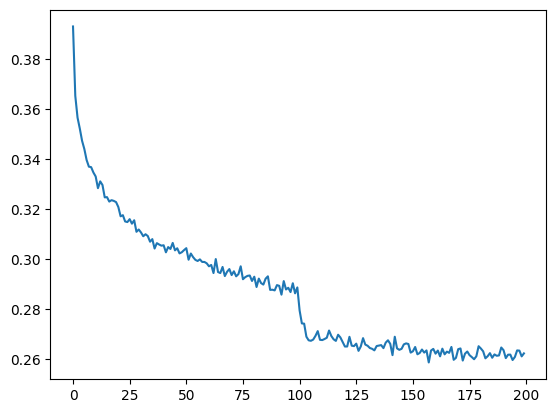

In [196]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [197]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [198]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.796010971069336
val 1.9880789518356323


The train loss and val loss are similar, suggesting that we are not overfitting the training data

In [199]:
# Sample from the model

for _ in range(20):
    out = []
    context = [0] * block_size # current context window size = 3
    while True:
        logits = model(torch.tensor([context])) # initialize with ...
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix] # shift the context window
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

fapnova.
athanaya.
raina.
yaheline.
shirino.
kaislyn.
jcoleh.
ayria.
lieler.
amanua.
klishan.
emeliana.
brenleigu.
daniyah.
corie.
chailee.
jaquaviour.
yaseia.
aariyana.
vanasos.
